In [652]:
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
import pandas as pd
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve
import numpy as np
import plotly.express as px
import shap
import seaborn as sns
from IPython import display
import matplotlib.pyplot as plt
import awswrangler as wr
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    multilabel_confusion_matrix,
)
from catboost.utils import select_threshold
from skmultilearn.model_selection.iterative_stratification import (
    IterativeStratification,
)
from sklearn.model_selection import StratifiedKFold, KFold
from tqdm import tqdm
from catboost.utils import get_roc_curve, select_threshold
from torchmetrics.classification import BinaryPrecisionRecallCurve
from supervised.automl import AutoML
import warnings
from loguru import logger

warnings.filterwarnings("ignore")


In [653]:
wr.config.s3_endpoint_url = "http://192.168.1.4:8333"

multilabelDf = wr.s3.read_parquet(
    path=f"s3://multilabel_df/",
    dataset=True,
)
multilabelDf.columns

Index(['vision_bonnet', 'vision_bumper_front', 'vision_grille',
       'vision_headlamp_rh', 'vision_headlamp_lh', 'vision_door_front_lh',
       'vision_door_front_rh', 'vision_engine', 'vision_bumper_rear',
       'vision_misc', 'vision_front_panel', 'vision_non_external',
       'vision_wheel', 'vision_fender_front_lh', 'vision_fender_front_rh',
       'vision_rear_quarter_lh', 'vision_tail_lamp_lh', 'vision_tail_lamp_rh',
       'vision_windscreen_front', 'vision_rear_compartment',
       'vision_rear_panel', 'vision_rear_quarter_rh', 'vision_door_rear_rh',
       'vision_door_rear_lh', 'bonnet', 'bumper_front', 'grille',
       'fog_lamp_rh', 'headlamp_lh', 'headlamp_rh', 'door_front_lh',
       'door_front_rh', 'air_conditioning', 'cooling_fan', 'radiator',
       'bumper_rear', 'misc', 'engine', 'airbag', 'front_panel',
       'undercarriage', 'wheel', 'fender_front_lh', 'fender_front_rh',
       'door_mirror_rh', 'rear_quarter_lh', 'interior', 'tail_lamp_lh',
       'fog_lamp_l

In [654]:
# multilabelDf.replace(pd.NA, 0, inplace=True)

In [655]:
multilabelDf["Assembly_Type"]

0         3
1         3
2         3
3         3
4         3
         ..
598121    3
598122    3
598123    3
598124    2
598125    3
Name: Assembly_Type, Length: 598126, dtype: Int64

In [656]:
multilabelDf[multilabelDf["Model"] == "NA"]

,vision_bonnet,vision_bumper_front,vision_grille,vision_headlamp_rh,vision_headlamp_lh,vision_door_front_lh,vision_door_front_rh,vision_engine,vision_bumper_rear,vision_misc,...,Assembly_Type,Vehicle_Still_Driveable,NCB_Stat,Claim_Type,Vehicle_Type,Sum_Insured,Repairer,Repairer_Apprv_Count,Collision_With,Handling_Insurer


In [657]:
wr.config.s3_endpoint_url = "http://192.168.1.4:8333"

multilabelDf = wr.s3.read_parquet(
        path=f"s3://multilabel_df/",
        dataset=True,
    )
allVisionFeatures = [x for x in multilabelDf.columns if "vision_" in x]
caseFeatures = [
    "Circumstances_of_Accident",
    "Model",
    # "Vehicle_Still_Driveable",
    # "NCB_Stat",
    # "Assembly_Type",
    "Claim_Type",
    # "Vehicle_Type",
    # # "Sum_Insured",
    # "Repairer",
    # # # "Repairer_Apprv_Count",
    # "Collision_With",
    # "Handling_Insurer",
]
exclude = ['Sum_Insured', 'Repairer', 'Repairer_Apprv_Count', 
"Vehicle_Still_Driveable",
    "NCB_Stat",
    "Assembly_Type",
    "Claim_Type",
    "Vehicle_Type",
    "Sum_Insured",
    "Repairer",
    "Repairer_Apprv_Count",
    "Collision_With",
    "Handling_Insurer"
     ]
# contFeatures = ["Sum_Insured", "Repairer_Apprv_Count"]
allInputFeature = caseFeatures + allVisionFeatures
allTargetCol = [
   'bonnet', 'bumper_front', 'grille', 'fog_lamp_rh', 'headlamp_lh', 'headlamp_rh', 'door_front_lh', 'door_front_rh', 'air_conditioning', 'cooling_fan', 'radiator', 'bumper_rear', 'misc', 'engine', 'airbag', 'front_panel', 'undercarriage', 'wheel', 'fender_front_lh', 'fender_front_rh', 'door_mirror_rh', 'rear_quarter_lh', 'interior', 'tail_lamp_lh', 'fog_lamp_lh', 'tail_lamp_rh', 'windscreen_front', 'rear_compartment', 'rear_panel', 'rear_quarter_rh', 'door_rear_rh', 'door_mirror_lh', 'door_rear_lh', 'windscreen_rear'
]
saloonPredDf = pd.read_csv(
    "/home/alextay96/Desktop/all_workspace/new_workspace/DLDataPipeline/data/results/saloon_focal_480_aug_2/Saloon - 4 Dr_imgs_pred_output.csv"
)
# hatchBackDf = pd.read_csv("/home/alextay96/Desktop/new_workspace/DLDataPipeline/data/results/hatchback_v2/Hatchback - 5 Dr_imgs_pred_output.csv")
# suvDf = pd.read_csv("/home/alextay96/Desktop/new_workspace/DLDataPipeline/data/results/suv_v2/SUV - 5 Dr_imgs_pred_output.csv")

# imgPredOutput = pd.concat([saloonPredDf, hatchBackDf, suvDf])
imgPredOutput = saloonPredDf
allPredModel = []
allPreds = []
allGt = []
realTestDataDf = multilabelDf[caseFeatures + allTargetCol + ["CaseID"]].merge(
    imgPredOutput, on="CaseID"
)
realTestDataDf = realTestDataDf.loc[
    :, ~realTestDataDf.columns.str.contains("^Unnamed")
]
trainDf = multilabelDf[
    ~multilabelDf["CaseID"].isin(realTestDataDf["CaseID"].unique().tolist())
]
# trainDf = trainDf.sample(frac=0.5)
assert set(realTestDataDf["CaseID"].tolist()).isdisjoint(trainDf["CaseID"].tolist())
targetPart = [
    "fog_lamp_rh",
    "door_front_lh",
    "door_front_rh",
    "airbag",
    "undercarriage",
    "wheel",
    "door_mirror_rh",
    "interior",
    "fog_lamp_lh",
    "windscreen_front",
    "door_mirror_lh",
    "door_rear_rh",
    "door_rear_lh",
    "windscreen_rear",
]
# targetPart = [
#      'bonnet', 'bumper_front', 'grille', 'headlamp_lh', 'headlamp_rh', 'door_front_lh', 'door_front_rh', 'bumper_rear', 'misc', 'engine', 'front_panel', 'wheel', 'fender_front_lh', 'fender_front_rh', 'rear_quarter_lh', 'interior', 'tail_lamp_lh', 'tail_lamp_rh', 'windscreen_front', 'rear_compartment', 'rear_panel', 'rear_quarter_rh', 'door_rear_rh', 'door_rear_lh'
# ]
# targetCol = list(set(targetPart) & set(allTargetCol))
targetCol = allTargetCol
print(len(trainDf))
print(targetCol)

588126
['bonnet', 'bumper_front', 'grille', 'fog_lamp_rh', 'headlamp_lh', 'headlamp_rh', 'door_front_lh', 'door_front_rh', 'air_conditioning', 'cooling_fan', 'radiator', 'bumper_rear', 'misc', 'engine', 'airbag', 'front_panel', 'undercarriage', 'wheel', 'fender_front_lh', 'fender_front_rh', 'door_mirror_rh', 'rear_quarter_lh', 'interior', 'tail_lamp_lh', 'fog_lamp_lh', 'tail_lamp_rh', 'windscreen_front', 'rear_compartment', 'rear_panel', 'rear_quarter_rh', 'door_rear_rh', 'door_mirror_lh', 'door_rear_lh', 'windscreen_rear']


In [658]:

for part in tqdm(targetCol):
    logger.success(f"Start training for part : {part}")
    allCaseIdByPart = []
    allPredByPart = []
    allGtByPart = []
    trainCaseId = trainDf["CaseID"].tolist()
    tempTestDataDf = realTestDataDf.groupby(part).head(2000)
    testCaseId = tempTestDataDf["CaseID"].tolist()
    # sampledDf = trainDf[allInputFeature + [part]].groupby(part).sample(frac=0.3)
    X_train = trainDf[allInputFeature]
    Y_train = trainDf[part].to_frame()
   
    X_test = tempTestDataDf[allInputFeature]
    Y_test = tempTestDataDf[part].to_frame()

    pos_count = len(Y_test[Y_test[part] == 1]) / len(Y_test)
    neg_count = len(Y_test[Y_test[part] == 0]) / len(Y_test)
    pos_weight = neg_count / pos_count
    train_pool = Pool(
        X_train, Y_train, cat_features=caseFeatures + allVisionFeatures
    )
    test_pool = Pool(X_test, Y_test, cat_features=caseFeatures + allVisionFeatures)
    # prCurve = MulticlassPrecisionRecallCurve(num_classes=2, thresholds=11)
    clf = CatBoostClassifier(
            loss_function="Logloss",
            eval_metric="F1",
            iterations=100,
            task_type="GPU",
            auto_class_weights="SqrtBalanced",
            # scale_pos_weight=20
            # class_names=["not_dmg", "dmg"],
        )
    clf.fit(train_pool, eval_set=test_pool, metric_period=20, plot=False, verbose=0)
    test_predict = clf.predict(X_test)

    test_predict = clf.predict(X_test)

    # (fpr, tpr, thresholds) = get_roc_curve(clf, test_pool, plot=False)
    # boundary = select_threshold(clf, curve=(fpr, tpr, thresholds), FPR=0.45)
    # clf.set_probability_threshold(boundary)
    # test_predict = clf.predict(X_test)

    acc = accuracy_score(Y_test.values.astype(np.int64), test_predict)
    confMat = confusion_matrix(Y_test.values.astype(np.int64), test_predict)
    pos_count = len(Y_test[Y_test[part] == 1]) / len(Y_test)
    tn = confMat[0][0]
    tp = confMat[1][1]
    fp = confMat[0][1]
    fn = confMat[1][0]
    totalSample = fp + fn + tp + tn
    acc = (tp + tn) / (fp + fn + tp + tn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    assert (tp / (tp + fn)) + (fn / (tp + fn)) == (tn / (tn + fp)) + (
        fp / (tn + fp)
    )

    allPredModel.append(
        {
            "part": part,
            "tp": tp / (tp + fn),
            "tn": tn / (tn + fp),
            "fp": fp / (tn + fp),
            "fn": fn / (tp + fn),
            "acc": acc,
            "precision": precision,
            "recall": recall,
            "f1": (2 * precision * recall) / (precision + recall),
            "pos_count": pos_count,
        }
    )
    assert len(testCaseId) == len(test_predict)
    assert len(testCaseId) == len(Y_test)

    allPreds.append({"CaseID": testCaseId, part: test_predict})
    allGt.append({"CaseID": testCaseId, part: Y_test.values.squeeze(1)})


  0%|          | 0/34 [00:00<?, ?it/s]2022-12-23 18:50:33.991 | SUCCESS  | __main__:<module>:2 - Start training for part : bonnet


In [ ]:

evalMetrics = pd.json_normalize(allPredModel)
avgPrecision = evalMetrics["precision"].mean()
avgRecall = evalMetrics["recall"].mean()
avgF1 = evalMetrics["f1"].mean()
avgTp = evalMetrics["tp"].mean()
avgFp = evalMetrics["fp"].mean()

avgTn = evalMetrics["tn"].mean()
avgAcc = evalMetrics["acc"].mean()
avgFn = evalMetrics["fn"].mean()

print(f"Avg Precision : {avgPrecision}")
print(f"Avg Recall : {avgRecall}")
print(f"Avg F1 : {avgF1}")
print(f"Avg TP : {avgTp}")
print(f"Avg TN : {avgTn}")
print(f"Avg FN : {avgFn}")

print(f"avgAcc : {avgAcc}")

Avg Precision : 0.7435975748818225
Avg Recall : 0.738706089517335
Avg F1 : 0.722882336528067
Avg TP : 0.738706089517335
Avg TN : 0.7234411764705883
Avg FN : 0.26129391048266504
avgAcc : 0.7437175538504908


In [ ]:
fig = px.bar(evalMetrics, x = 'part', y = 'tp')

fig.add_hline(y=avgTp, line_width=2, line_color="red")

fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgTp, 2), 0.2, 0.5, 0.7],
    )
)
fig

In [ ]:
fig = px.bar(evalMetrics, x = 'part', y = 'fp')

fig.add_hline(y=avgFp, line_width=2, line_color="red")

fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgFp, 2), 0.2, 0.5, 0.7],
    )
)

In [ ]:
fig = px.bar(evalMetrics, x = 'part', y = 'tn')

fig.add_hline(y=avgTn, line_width=2, line_color="red")

fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgTn, 2), 0.2, 0.5, 0.7],
    )
)
fig

In [ ]:
fig = px.bar(evalMetrics, x = 'part', y = 'fn')

fig.add_hline(y=avgFn, line_width=2, line_color="red")

fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgFn, 2), 0.2, 0.5, 0.7],
    )
)
fig

In [ ]:
fig = px.bar(evalMetrics, x = 'part', y = 'acc')

fig.add_hline(y=avgAcc, line_width=2, line_color="red")

fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgAcc, 2), 0.2, 0.5, 0.7],
    )
)

In [ ]:
fig = px.bar(evalMetrics, x = 'part', y = 'precision')

fig.add_hline(y=avgPrecision, line_width=2, line_color="red")

fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgPrecision, 2), 0.2, 0.5, 0.7],
    )
)
fig

In [ ]:
fig = px.bar(evalMetrics, x = 'part', y = 'recall')

fig.add_hline(y=avgRecall, line_width=2, line_color="red")

fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgRecall, 2), 0.2, 0.5, 0.7],
    )
)
fig

In [ ]:
fig = px.bar(evalMetrics, x = 'part', y = 'f1')

fig.add_hline(y=avgF1, line_width=2, line_color="red")

fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgF1, 2), 0.2, 0.5, 0.7],
    )
)
fig

In [ ]:
multilabelPred = pd.DataFrame(pd.DataFrame(allPreds[0]))
for p in tqdm(allPreds[1:]):
    dfPart = pd.DataFrame(p)
    multilabelPred = multilabelPred.merge(dfPart, on="CaseID")
multilabelPred.sort_values(by="CaseID", inplace=True)
multilabelPred

100%|██████████| 33/33 [00:00<00:00, 213.31it/s]


,CaseID,bonnet,bumper_front,grille,fog_lamp_rh,headlamp_lh,headlamp_rh,door_front_lh,door_front_rh,air_conditioning,...,fog_lamp_lh,tail_lamp_rh,windscreen_front,rear_compartment,rear_panel,rear_quarter_rh,door_rear_rh,door_mirror_lh,door_rear_lh,windscreen_rear
390,10000038,1,1,1,1,1,1,0,0,1,...,0,1,0,1,1,0,0,0,0,0
391,10000181,1,1,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
392,10000193,1,1,1,0,1,1,0,1,1,...,0,0,1,0,0,0,0,0,0,0
393,10000201,1,1,0,1,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
394,10000234,1,1,0,0,1,1,1,0,1,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,13047834,1,1,0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
105,13049956,1,1,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
106,13052044,1,1,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
388,13063884,1,1,1,0,1,1,0,1,1,...,0,1,1,1,1,1,1,0,1,1


In [ ]:
multilabelGt = pd.DataFrame(pd.DataFrame(allGt[0]))
for p in tqdm(allGt[1:]):
    dfPart = pd.DataFrame(p)
    multilabelGt = multilabelGt.merge(dfPart, on="CaseID")
multilabelGt.sort_values(by="CaseID", inplace=True)

100%|██████████| 33/33 [00:00<00:00, 217.30it/s]


In [ ]:
multilabelGt = multilabelGt[multilabelPred.columns]
multilabelGt

,CaseID,bonnet,bumper_front,grille,fog_lamp_rh,headlamp_lh,headlamp_rh,door_front_lh,door_front_rh,air_conditioning,...,fog_lamp_lh,tail_lamp_rh,windscreen_front,rear_compartment,rear_panel,rear_quarter_rh,door_rear_rh,door_mirror_lh,door_rear_lh,windscreen_rear
390,10000038,1,1,1,0,1,1,0,0,1,...,1,1,0,1,1,0,0,0,0,0
391,10000181,1,1,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
392,10000193,1,1,1,0,1,1,0,1,1,...,0,0,1,0,0,0,0,0,0,0
393,10000201,1,1,0,1,1,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
394,10000234,1,1,1,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,13047834,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
105,13049956,1,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
106,13052044,1,1,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
388,13063884,1,1,1,1,0,1,0,0,1,...,0,1,1,1,1,1,0,0,0,1


In [ ]:
def hamming_score(y_true, y_pred):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = np.divide(len(set_true.intersection(set_pred)), 
                    float( len(set_true) ))
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean( [x for x in acc_list if not np.isnan(x)]), acc_list

In [ ]:
# tempTargetCol = ["airbag", "undercarriage", "interior"]

In [ ]:
subsetAcc2, acc_list = hamming_score(multilabelGt[targetCol].values, multilabelPred[targetCol].values)
subsetAcc2

0.8311844822971778

In [ ]:
evalData = pd.DataFrame(
    [
        {
            "metric" : "subset_accuracy",
            "value" : subsetAcc2

        },
         {
            "metric" : "avg_tpr",
            "value" : avgTp

        },
        {
            "metric" : "avg_tnr",
            "value" : avgTn

        },
        {
            "metric" : "part_recall",
            "value" : avgRecall

        },
            {
            "metric" : "part_precision",
            "value" : avgPrecision

        },
                {
            "metric" : "part_accuracy",
            "value" : avgAcc

        }
    ]
)


In [ ]:
fig = px.bar(evalData, x = 'metric', y = 'value', text_auto=True)
fig

In [ ]:
targetCol[-1]

'windscreen_rear'

In [ ]:
clf.classes_

array([0, 1])

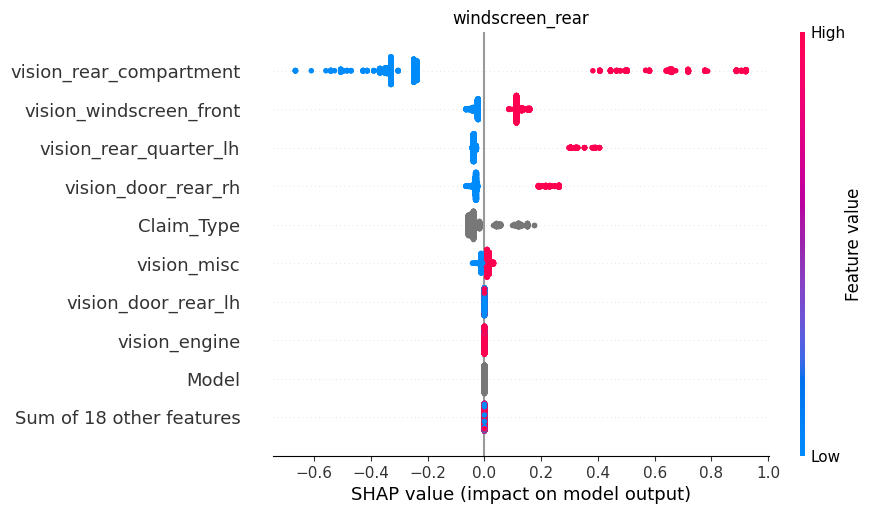

In [ ]:
explainer = shap.Explainer(clf)
shap_values = explainer(X_test)
plt.title(targetCol[-1])
shap.plots.beeswarm(shap_values)


In [ ]:
caseStudyPred = multilabelPred.sample(n=30).head(30)
caseStudyGt = multilabelGt[multilabelGt["CaseID"].isin(caseStudyPred["CaseID"].unique().tolist())]
caseStudyPred.to_csv("case_study_pred.csv")
caseStudyGt.to_csv("case_study_gt.csv")